In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from transform import LinearTransform
from transform import MultiLayerPerceptron as MLP
from aevb import AutoEncodingVariationalBayes as vae
from aevb import FLDSVB
from dynamics import FLDS, KalmanFilter
from model import ReparameterizedDistribution
from distribution import MultiplicativeNormal
from vis.dynamic import plot_paths

# Generating Synthetic Data Set

Generating Synthetic Data Set
We consider the Kalman Filter model with diagonal covariances. Latent variables are denoted by $z_1, \ldots, z_T \in \mathbb{R}^{d}$ and observations are denoted by $x_1, \ldots, x_T \in \mathbb{R}^{m}$.

- $z_1 \sim \mathcal{N}(\mu_1, \sigma_1\mathbf{I})$
- $z_t \sim \mathcal{N}(\mathbf{A}z_{t-1} + b, \sigma\mathbf{I})$ for $t=2, \ldots, T$
- $y_t \sim \mathcal{N}(z_t, s\mathbf{I})$ for $t=1, \ldots, T$
- $x_t = \sin(\frac{y_t}{10} )$


In [2]:
DIM = 3
LAT_DIM = 2
TIME = 10
N_EXAMPLES = 100 # Total number of paths

TRANSITION_MATRIX = np.array([[1.4, -1.6], [.4, .2], [0., 0.]])


with tf.Graph().as_default():
    
    kf = KalmanFilter(lat_dim=LAT_DIM, obs_dim=DIM,
              time_steps=TIME,
              init_transition_matrix_bias=TRANSITION_MATRIX, full_covariance=False)
    samples = kf.sample(N_EXAMPLES)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        data = sess.run(samples)

In [8]:
DATA = np.squeeze(np.matmul(
    data[0][:, :, None, :], np.random.normal(0, 1, [1, 1, 2, 3])))
DATA = np.sin(1./10 * DATA)

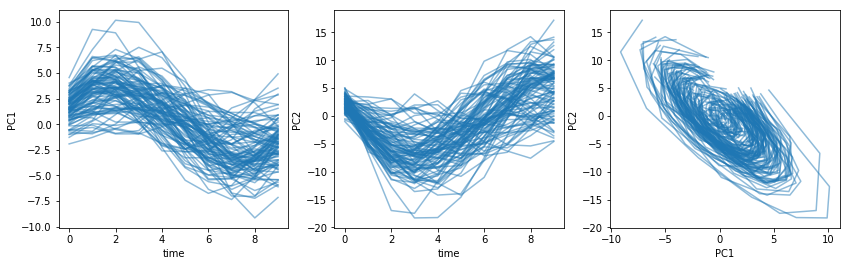

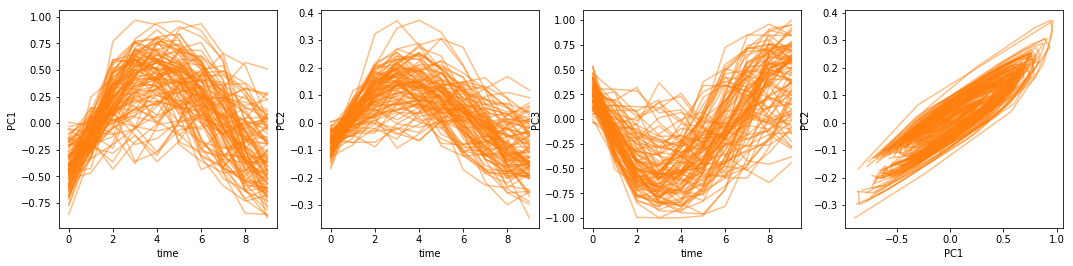

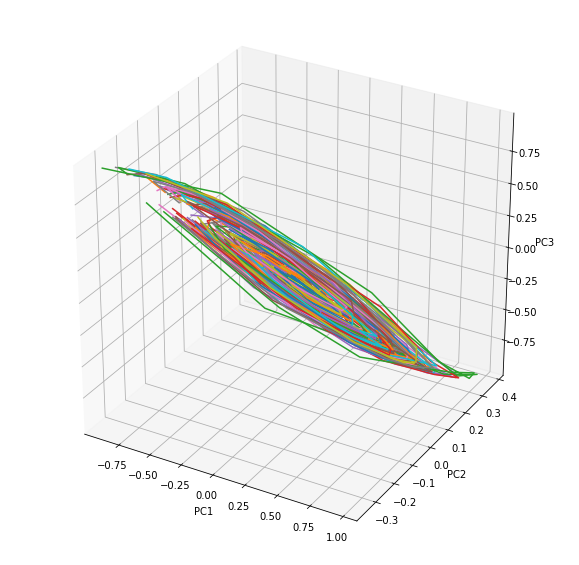

In [9]:
plot_paths(data[0], c="C0", alpha=0.5)
plt.gcf().set_size_inches(14, 4)

plot_paths(DATA, c="C1", alpha=0.5)
plt.gcf().set_size_inches(18, 4)

plot_paths(DATA, c="C0", three_dim=True, alpha=0.5)
plt.gcf().set_size_inches(10, 10)


# Setting Up the fLDS model

parameters that the `FLDSVB` which is an extension of the `AutoEncodinVariationalBayes` is the following:

- `data` with shape (# examples, # time steps, # dimensions)
- `lat_dim`: dimensionality of the latent space
- `n_monte_carlo_samples`: Number of Monte Carlo samples for estimating gradients
- `batch_size`
- `optimizer` which is a tensor flow optimizer
- type of non-linear transformation and it's architecture parameters (In the library there are basic transforms (planning on adding more...)

In [10]:
STEPS = 2000

BATCH_SIZE = 1
SAMPLE_SIZE = 1

MODEL_LAYERS = [40, 20]
RECOGNITION_LAYERS = [40, 20]

graph = tf.Graph()

recon_idx = range(10)

with graph.as_default():

    v = FLDSVB(data=DATA, lat_dim=LAT_DIM, nonlinear_transform=MLP,
               n_monte_carlo_samples=SAMPLE_SIZE, batch_size=BATCH_SIZE,
               optimizer=tf.train.AdamOptimizer(learning_rate=0.001), full_covariance=False,
               hidden_units=[50, 50])
    # Losses
    l = v.train(steps=STEPS)
    # Get reconstruction and code for some training samples
    r = v.get_reconstructions(recon_idx)
    c = v.get_codes(recon_idx)

100%|██████████| 2000/2000 [00:20<00:00, 99.17it/s]


Text(0.5,0,'Iterations')

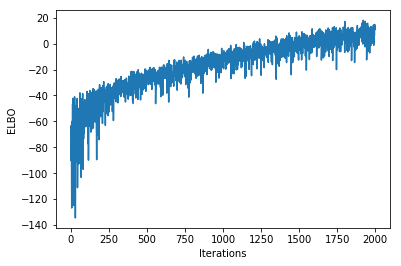

In [11]:
plt.plot(l)
plt.ylabel("ELBO")
plt.xlabel("Iterations")

# Learn, learn, learn...!

In [24]:
with graph.as_default():
    l += v.train(steps=2*STEPS)
    r = v.get_reconstructions(recon_idx)
    c = v.get_codes(recon_idx)

100%|██████████| 4000/4000 [00:31<00:00, 126.09it/s]


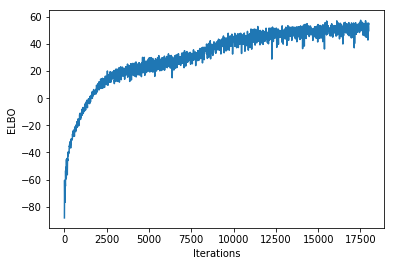

In [25]:
skip = 10
plt.plot(range(len(l))[::skip], np.mean(np.reshape(l, [-1, skip]), axis=-1))
plt.ylabel("ELBO")
plt.xlabel("Iterations")
plt.show()

Text(0.5,1,'Latnet paths from training Data')

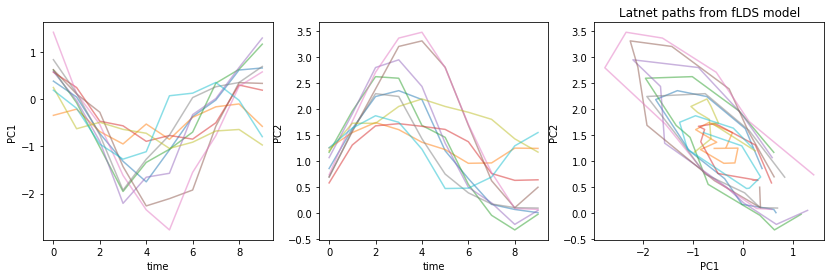

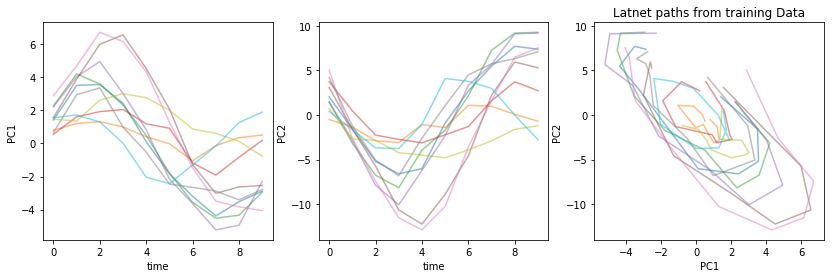

In [29]:
plot_paths(np.concatenate(c, axis=0), alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Latnet paths from fLDS model")

plot_paths(data[0][:10, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Latnet paths from training Data")

Text(0.5,1,'Reconstructions from fLDS model')

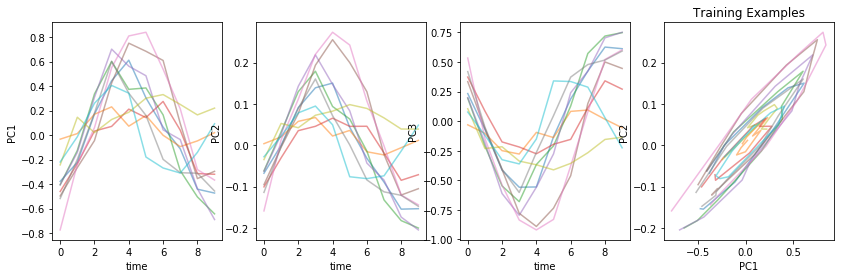

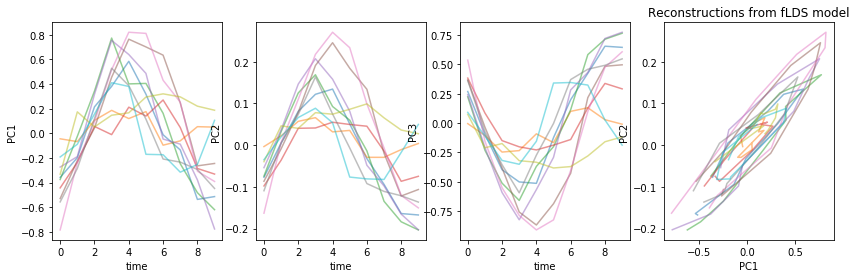

In [28]:
plot_paths(DATA[:10, :, :], alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Training Examples")

plot_paths(np.concatenate(r, axis=0), alpha=0.5)
plt.gcf().set_size_inches(14, 4)
plt.title("Reconstructions from fLDS model")